# Data-driven discovery of Nonlinear PDE

Burgers equation:  
$$ u_t + \lambda_1 u u_x - \lambda_2 u u_{xx}  = 0$$

Define f:
$$ f:=u_t + \lambda_1 u u_x - \lambda_2 u u_{xx} $$

<img src="models.png" width="400">


Train a model with the following loss fct: 
$$ LOSS = MSE_u + MSE_f =  MSE(u_{est}, u_{true}) + MSE(f_{est}, {0}) $$

$MSE_u$ fits the data

$MSE_f$ fits the known PDE

Learn NN weight, biases and Lambdas

In [2]:
import torch
import itertools
import math

from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from torch.nn import MSELoss
from torch import nn
from torch.utils.data import Dataset, DataLoader


Bad key "text.kerning_factor" on line 4 in
C:\Users\thiba\anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
class PhysicsInformedNN(nn.Module):

    def __init__(self, X, u, layers_struc, lb, ub):
        super(PhysicsInformedNN, self).__init__()

        #bounds
        self.lb = torch.tensor(lb, dtype=torch.float32)
        self.ub = torch.tensor(ub, dtype=torch.float32)

        #data
        self.x = torch.tensor(X[:, 0:1], dtype=torch.float32, requires_grad=True)
        self.t = torch.tensor(X[:, 1:2], dtype=torch.float32, requires_grad=True)
        self.u = torch.tensor(u, dtype=torch.float32)  # target data

        #layer struct
        self.layers_struc = layers_struc

        #model
        last_layer = nn.Linear(layers_struc[-2], 1)
        self.layers_u = \
            [nn.Sequential(nn.Linear(input_, output_), nn.Tanh())
             for input_, output_ in
             zip(layers_struc[:-2], layers_struc[1:-2])] + \
            [last_layer]

        self.net_u = nn.Sequential(*self.layers_u)


        # Initialize parameters
        tensor = torch.ones((2,), dtype=torch.float32)
        lambda_1 = tensor.new_tensor([0.0], requires_grad = False)
        lambda_2 = tensor.new_tensor([-6.0], requires_grad = False)
        self.lambda_1 = torch.nn.Parameter(lambda_1)
        self.lambda_2 = torch.nn.Parameter(lambda_2)

        self.optimizer = None

    def forward(self, x, t):
        #Normalize
        x = 2.0 * (x - self.lb[0]) / (self.ub[0] - self.lb[0]) - 1.0
        t = 2.0 * (t - self.lb[1]) / (self.ub[1] - self.lb[1]) - 1.0
        
        #NET U
        u = self.net_u(torch.cat((x,t)))
    
        
        #NET F
        lambda_1 = self.lambda_1
        lambda_2 = torch.exp(self.lambda_2)
        u_t = torch.autograd.grad(u, t, retain_graph=True)[0]
        u_x = torch.autograd.grad(u, x, retain_graph=True, create_graph=True)[0]  # TODO check gradients
        u_xx = torch.autograd.grad(u_x, x, retain_graph=True)[0]
        if(math.isnan(u_t.item())):
            print("U differential is nan !!")
        
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx

        return u, f

    def loss_fn(self, u_out, f_out, target):
        loss = nn.MSELoss()
        MSE_u = loss(u_out, target)
        MSE_f = loss(f_out, torch.tensor([0], dtype=torch.float32))
        return MSE_u + MSE_f

    def train(self, nIter):
        print("Start Training")
        
        for i in range(nIter):
            running_loss = 0.0
            it = 0
            
            for (x_in, t_in, target) in zip(self.x, self.t, self.u):
                
                def closure():
                    self.optimizer.zero_grad()
                    u_est, f_est = self(x_in,t_in)
                    loss = self.loss_fn(u_est, f_est, target)
                    loss.backward()

                    return loss
            
                self.optimizer.step(closure)

                loss = closure()
                #print(it)
                #if (it%10) == 0:
                print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, self.lambda_1.item(), np.exp(self.lambda_2.item())))
                it = it+1
                running_loss += loss.item()

            print("iter_loss:", running_loss)

In [4]:
#model and training params
nu = 0.01 / np.pi 
N_u = 2000
layers = [2, 20, 20, 20, 20, 20, 20, 20, 20, 1]

In [5]:
#Load data
data = scipy.io.loadmat('./PINNS/Data/burgers_shock.mat')
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T

X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Domain bounds
lb = X_star.min(0)
ub = X_star.max(0)

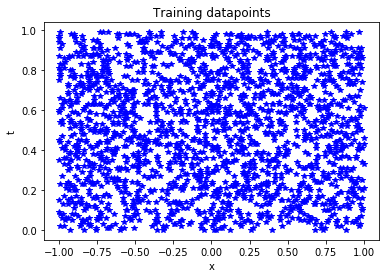

In [6]:
##GET NOISELESS DATA
noise = 0.0

#select N_u training points
idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

plt.plot(X_u_train[:, 0:1], X_u_train[:, 1:2], 'b*')
plt.xlabel("x")
plt.ylabel("t")
plt.title("Training datapoints")
plt.show()

In [7]:
def xavier_init_routine(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0)

In [8]:
##MODEL
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)
model.apply(xavier_init_routine)

# model.optimizer = torch.optim.SGD(par, lr=0.01)
model.optimizer = torch.optim.LBFGS(model.parameters(), max_iter=50000, max_eval=50000,
                                        tolerance_grad=1.0 * np.finfo(float).eps)

print(model)
print(model.optimizer)

PhysicsInformedNN(
  (net_u): Sequential(
    (0): Sequential(
      (0): Linear(in_features=2, out_features=20, bias=True)
      (1): Tanh()
    )
    (1): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (2): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (3): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (4): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (5): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (6): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
    )
    (7): Linear(in_features=20, out_features=1, bias=True)
  )
)
LBFGS (
Parameter Group 0
    history_size: 100
    line_search_fn: None
    lr: 1
    max_eval: 50000
    max_iter: 50000
    tolerance_change: 

C:\Users\thiba\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until


In [33]:
#Training
model.train(1)

Start Training
Loss: 2.459876e-11, l1: 0.23407, l2: 0.00248
Loss: 1.066238e-12, l1: -48.72098, l2: 0.00311
Loss: 1.163866e-10, l1: -49.04966, l2: 0.00311
Loss: 1.156742e-11, l1: -37.58050, l2: 0.00295
Loss: 1.225192e-10, l1: -40.32740, l2: 0.00299
Loss: 8.473897e-11, l1: -24.57957, l2: 0.00278
Loss: 3.282154e-13, l1: -29.55697, l2: 0.00284
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differential is nan !!
U differ

KeyboardInterrupt: 

In [ ]:
u_pred, f_pred = model.predict(X_star)

error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)

U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)

error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100

print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))


## NEXT STEPS

- Make it work !
- Try weighting the MSEs ?
- Try other optimizers ?
- What about different architecures?